In [1]:
from pathlib import Path

import numba as nb
import numpy as np
import scipy.stats as stats

from natsort import natsorted

import matplotlib.pyplot as plt


#plt.style.use("mike")
#import warnings
#warnings.simplefilter("ignore")
#warnings.filterwarnings('ignore')


import astropy.units as u

import cmasher as cmr

green = "#33FF86"
purple = "#CE33FF"

%matplotlib widget
from cosmogrb.universe.survey import Survey

import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from zusammen.stan_models.stan_model import get_model
from zusammen import AnalysisBuilder, DataSet
from zusammen.spectral_plot import display_posterior_model_counts

from threeML import update_logging_level

import arviz as av


update_logging_level("FATAL")


from astromodels import Band_Calderone, PointSource, Model


from threeML import JointLikelihood, DataList, display_spectrum_model_counts

from astromodels import Cutoff_powerlaw

import popsynth as ps

21:05:47 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=873788;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=895493;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py#50\50]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=712060;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=572100;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py#71\71]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=892549;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=174479;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

21:05:47 INFO      Starting 3ML!                                                                     ]8;id=544132;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=18230;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#31\31]8;;\

         WARNING   no display variable set. using backend for graphics without display (agg)         ]8;id=93634;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=821725;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   ROOT minimizer not available                                                ]8;id=876478;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=649553;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=641446;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=905222;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=424722;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=155696;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=621721;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=715768;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#79\79]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=753232;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=702196;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#129\129]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=918354;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=514558;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#129\129]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=113709;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=697289;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=72817;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=246252;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#341\341]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=928459;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=216181;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#341\341]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=396592;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=150022;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#341\341]8;;\
                  performances in 3ML                                                                              

Import the survey and process the GRBs

SynthGRB_0


Fitting GBM_n1 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_n0 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_n2 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_b0 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/5 [00:00<?, ?it/s]

SynthGRB_1


Fitting GBM_na background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

Fitting GBM_nb background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

Fitting GBM_n2 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

Fitting GBM_b1 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

SynthGRB_2


Fitting GBM_n7 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/14 [00:00<?, ?it/s]

Fitting GBM_n6 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/14 [00:00<?, ?it/s]

Fitting GBM_nb background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/14 [00:00<?, ?it/s]

Fitting GBM_b1 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/14 [00:00<?, ?it/s]

SynthGRB_3


Fitting GBM_n3 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting GBM_n6 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting GBM_n7 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting GBM_b0 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/1 [00:00<?, ?it/s]

SynthGRB_4


Fitting GBM_n2 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting GBM_n5 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting GBM_n1 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting GBM_b0 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/8 [00:00<?, ?it/s]

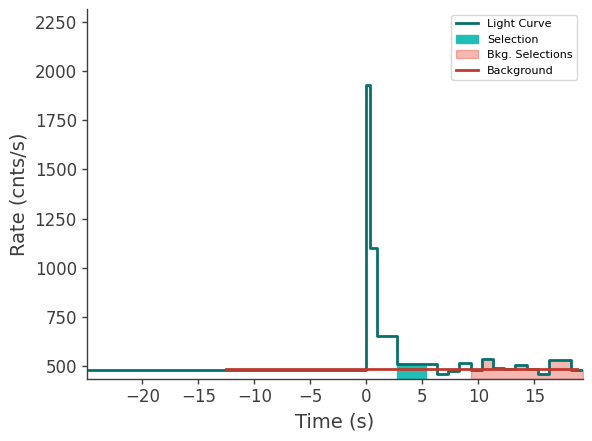

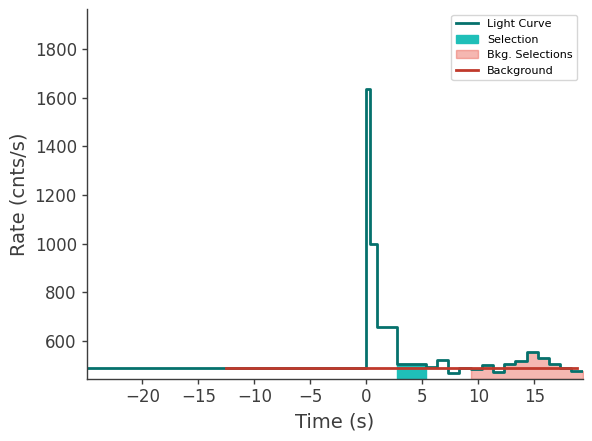

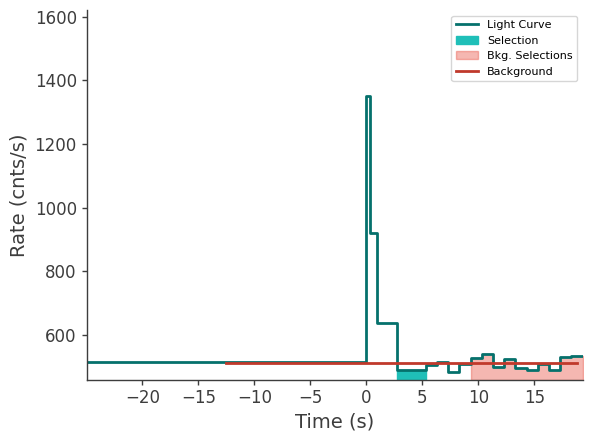

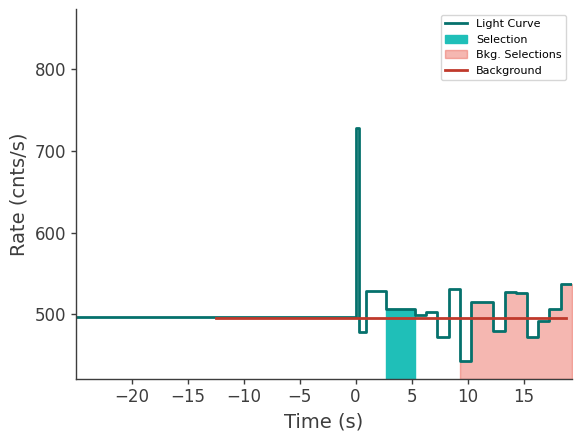

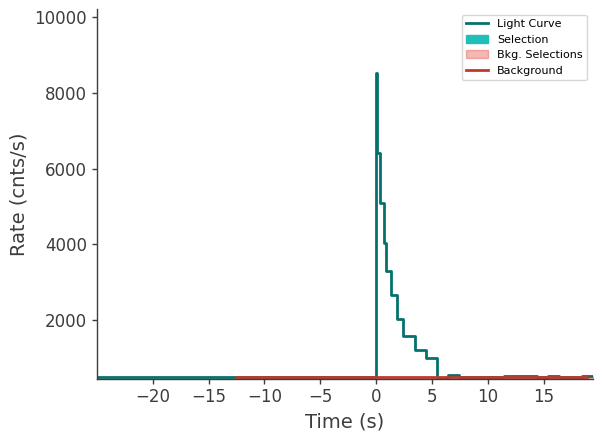

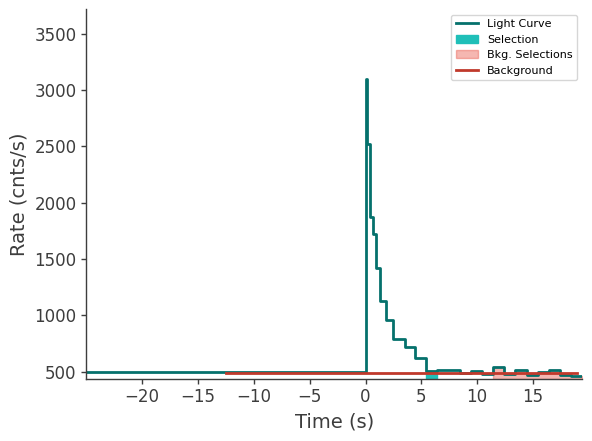

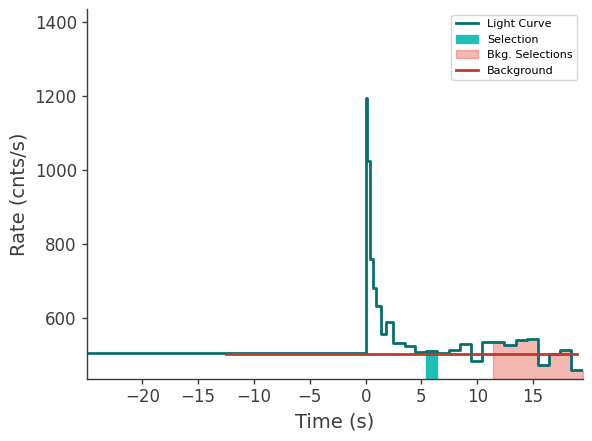

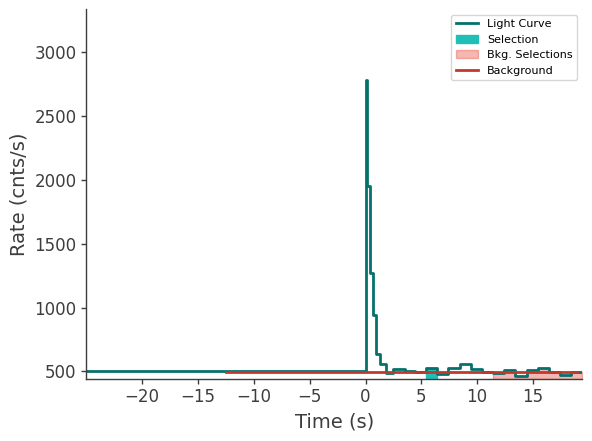

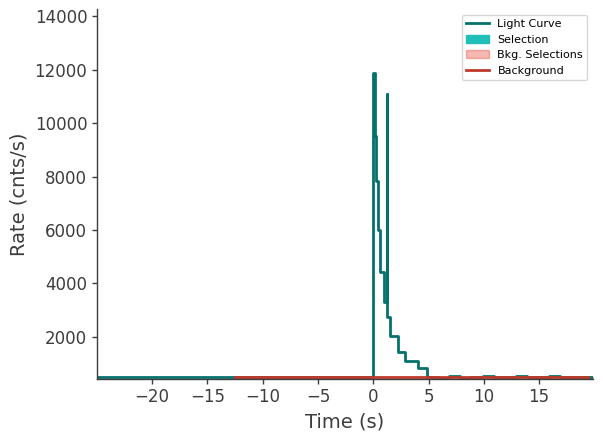

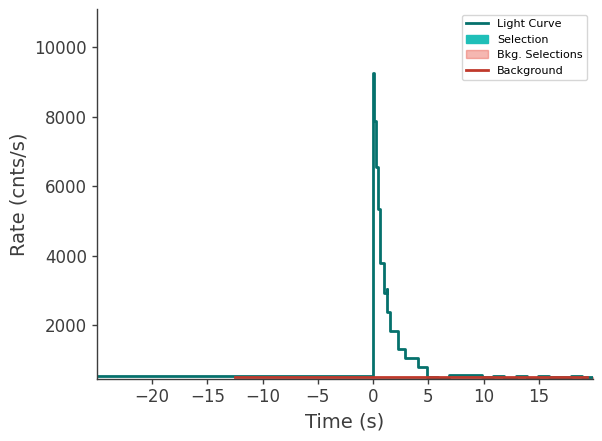

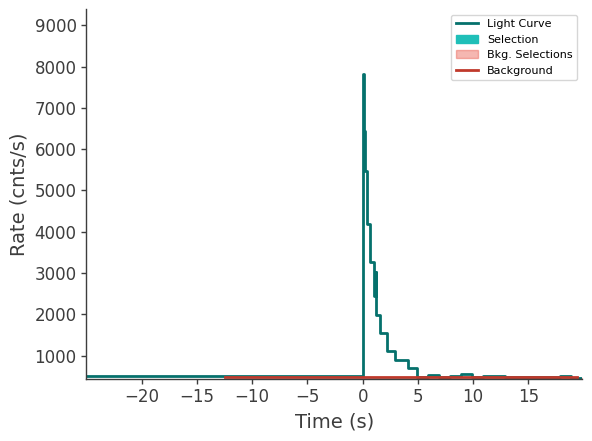

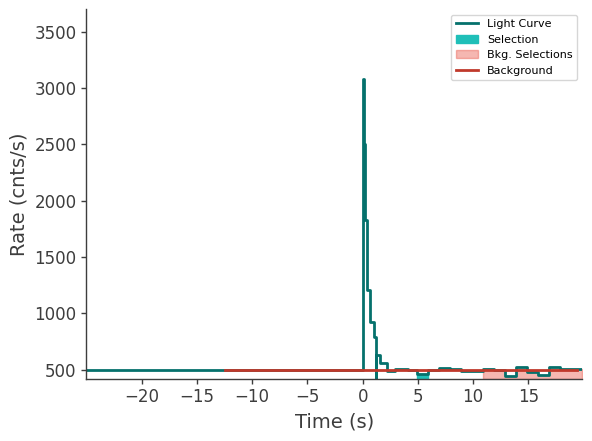

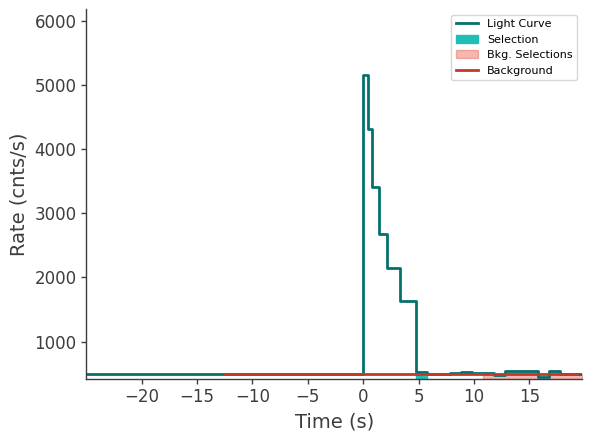

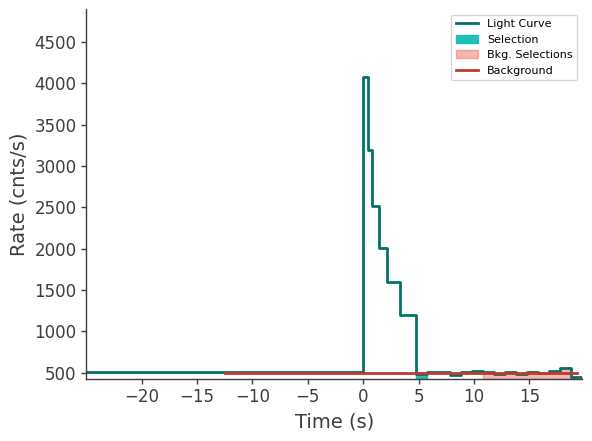

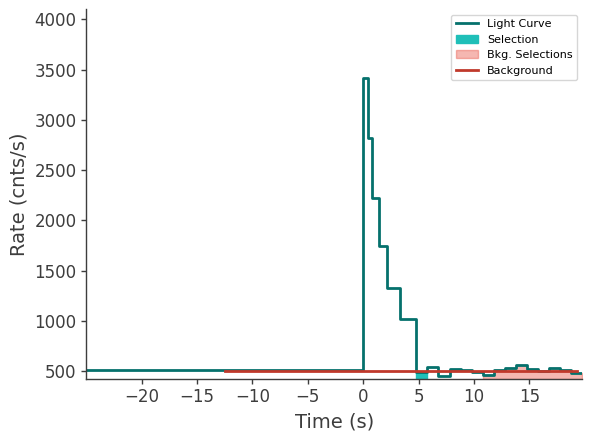

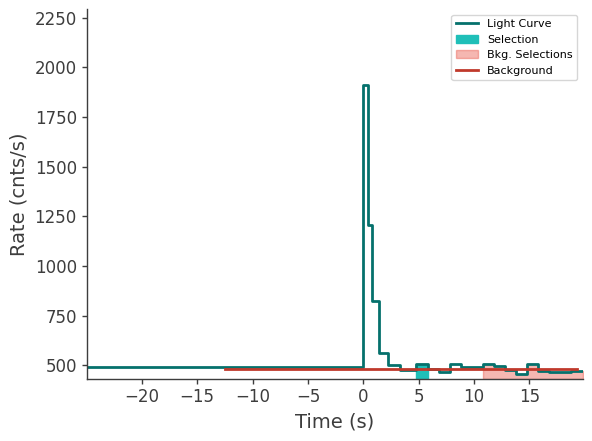

In [16]:
survey = Survey.from_file('data/survey.h5')
ab = AnalysisBuilder(survey, use_bb=True, sig_min=5)

In [17]:
ab.write_yaml("test_proc.yml")

In [18]:
ds = DataSet.from_yaml("test_proc.yml")

In [19]:
ds.to_hdf5_file("sgrb.h5")

In [ ]:
ds = DataSet.from_hdf5_file('sgrb.h5')

In [20]:
ds.to_stan_dict()

OrderedDict([('N_intervals', 13),
             ('N_grbs', 4),
             ('max_n_echan', 140),
             ('max_n_chan', 128),
             ('object_idx', array([1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4])),
             ('grb_id', array([1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4])),
             ('N_dets', [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
             ('observed_counts',
              array([[[ 55.,   5.,   5., ...,   0.,   0.,   5.],
                      [  1.,   2.,   0., ...,   0.,   0.,   9.],
                      [  0.,   1.,   4., ...,   0.,   4.,  16.],
                      [  0.,   2.,   0., ...,   0.,   6.,   6.]],
              
                     [[117.,  52.,  37., ...,   0.,   0.,   4.],
                      [  0.,   0.,   0., ...,   0.,   3.,   1.],
                      [  7.,   3.,   2., ...,   0.,   2.,   4.],
                      [  1.,   1.,   0., ...,   0.,   0.,   3.]],
              
                     [[183.,  79.,  43., ...,   0.,   0.,   4.],
   

In [ ]:
maxl = []
for i,j in enumerate(ds.to_stan_dict()["observed_counts"]):
    maxl.append(j.max())
    print(i, j.max())

print(max(maxl))

In [ ]:
%matplotlib widget
i,j = 0,0
plt.plot(ds.to_stan_dict()["response"][i,j].T @ ds.to_stan_dict()['observed_counts'][i,j])

Make Stan model

In [21]:
m = get_model("cpl_simple_chunked_gc")

In [ ]:
m.clean_model()

In [22]:
m.build_model(opt_exp=True)

In [33]:
data = ds.to_stan_dict()

n_threads = 2
n_chains = 2

fit = m.model.sample(
    data=data,
    parallel_chains=n_chains,
    chains=n_chains,
    inits= {
        'alpha': -1 * np.ones(data['N_intervals']),
        'log_ec': 2 * np.ones(data['N_intervals']),

        'log_energy_flux': -7 * np.ones(data['N_intervals']),
        # 'log_energy_flux_mu_raw': 0.00001,

        # 'gamma_sig_meta': 1,
        # 'log_Nrest_sig_meta': 1,
        # 'gamma_mu_meta': 1,
        # 'log_Nrest_mu_meta': 52,
        # 'gamma': np.ones(data['N_grbs']),
        # 'log_Nrest': 52 * np.ones(data['N_grbs'])
    },
    threads_per_chain=n_threads,
    seed=1234,
    iter_warmup=1000,
    iter_sampling=500,
    max_treedepth=12,
    adapt_delta=0.95,
    step_size=0.1,
    show_progress=True,
    # show_console=True
)

08:58:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

11:29:29 - cmdstanpy - INFO - CmdStan done processing.
11:29:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: integrate: error estimate of integral 5.09252e-15 exceeds the given relative tolerance times norm of integral (in '/Users/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 151, column 4 to column 105)
	Exception: integrate: error estimate of integral 1.00396e-75 exceeds the given relative tolerance times norm of integral (in '/Users/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 151, column 4 to column 105)
	Exception: integrate: error estimate of integral 6.61167e-06 exceeds the given relative tolerance times norm of integral (in '/Users/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 151, column 4 to column 105)
	Exception: integrate: error estimate of integral 6.73111e-05 exceeds the given relative tolerance times norm of integral (in '/Users/chrobin/Doc

In [ ]:
fit

In [ ]:
fit.diagnose()

Import Stan results into arviz

In [28]:
res = av.from_cmdstanpy(fit)

In [29]:
res.to_netcdf("inference_data/testing_gc_hierarchical_5_grbs_2.nc")

'inference_data/testing_gc_hierarchical_5_grbs_2.nc'

In [ ]:
res = av.from_netcdf("inference_data/testing_gc_5_grbs.nc")

In [30]:
res.sample_stats.tree_depth.max()

<xarray.DataArray 'tree_depth' ()>
array(8)

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'log_ec'}>,
        <AxesSubplot:title={'center':'log_ec'}>],
       [<AxesSubplot:title={'center':'log_Nrest'}>,
        <AxesSubplot:title={'center':'log_Nrest'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'gamma_mu_meta'}>,
        <AxesSubplot:title={'center':'gamma_mu_meta'}>],
       [<AxesSubplot:title={'center':'log_Nrest_mu_meta'}>,
        <AxesSubplot:title={'center':'log_Nrest_mu_meta'}>],
       [<AxesSubplot:title={'center':'gamma_sig_meta'}>,
        <AxesSubplot:title={'center':'gamma_sig_meta'}>],
       [<AxesSubplot:title={'center':'log_Nrest_sig_meta'}>,
        <AxesSubplot:title={'center':'log_Nrest_sig_meta'}>],
       [<AxesSubplot:title={'center':'ec'}>,
        <AxesSubplot:title={'center':'ec'}>],
       [<AxesSubplot:title={'center':'l

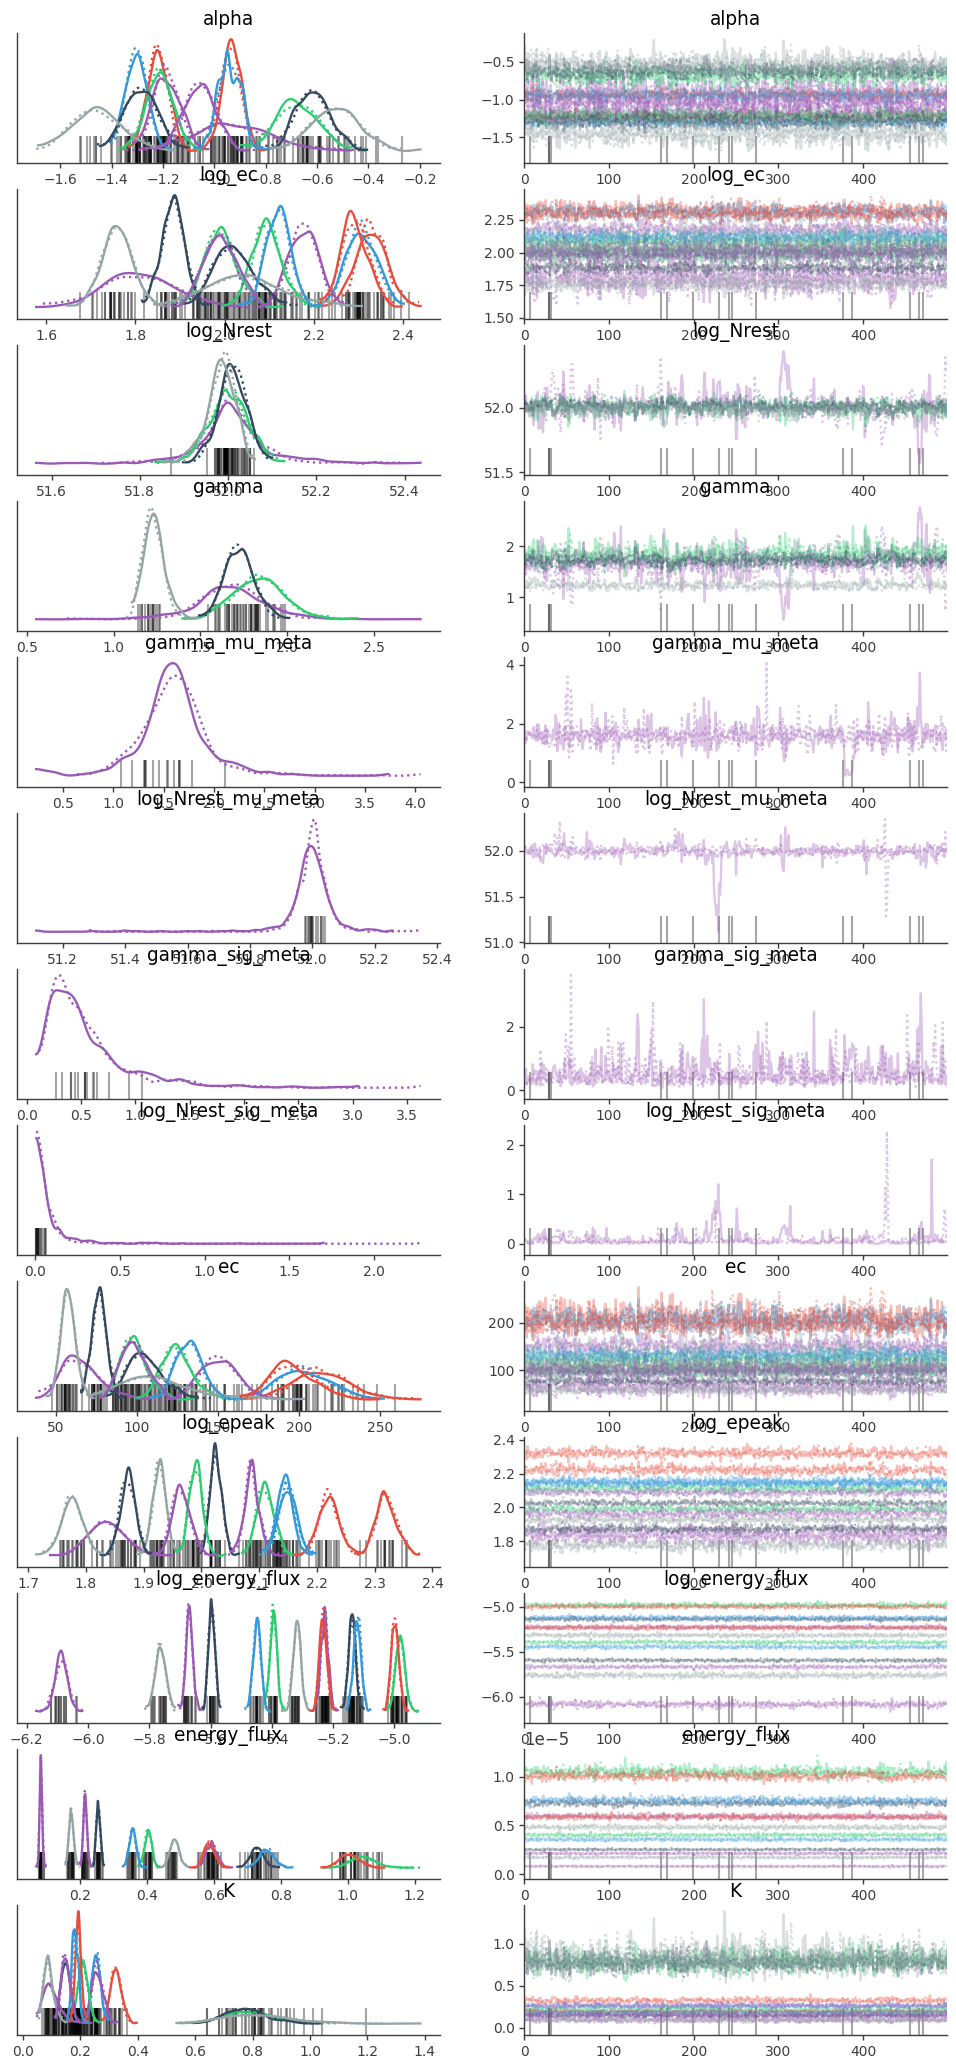

In [31]:
%matplotlib widget
av.plot_trace(res)

In [ ]:
%matplotlib widget
av.plot_pair(res, divergences=True)

In [ ]:
div = res.sample_stats.diverging.stack(sample=("chain", "draw")).values
div.sum()

Load parameters  

In [ ]:
id = 0


alpha = res.posterior.alpha.stack(sample=("chain", "draw")).values[id]

log_ec = res.posterior.log_ec.stack(sample=("chain", "draw")).values[id]

K  = res.posterior.K.stack(sample=("chain", "draw")).values[id]

# log_epeak = res.posterior.log_epeak.stack(sample=("chain", "draw")).values[id]

energy_flux = res.posterior.energy_flux.stack(sample=("chain", "draw")).values[id]

# gamma = res.posterior.gamma.stack(sample=("chain", "draw")).values[id]

# log_Nrest = res.posterior.log_Nrest.stack(sample=("chain", "draw")).values[id]


div = res.sample_stats.diverging.stack(sample=("chain", "draw")).values

samples = np.vstack((K, alpha, 10.**log_ec))


dl = ds.get_data_list_of_interval(id)

In [ ]:
div.sum()

In [ ]:
bc = Cutoff_powerlaw(piv=100)

bc.index.bounds = (None, None)
bc.K.bounds = (None, None)
bc.xc.bounds = (None, None)

model = Model(PointSource("ps",0,0, spectral_shape=bc))

In [ ]:
%matplotlib widget
#fig, ax = plt.subplots()

plt.scatter(log_ec, alpha, alpha=0.1)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(K, alpha, alpha=0.1)

In [ ]:
display_posterior_model_counts(
    dl[1], model, samples.T[::20], min_rate=1e-99, shade=False
)

In [ ]:
cpl = Cutoff_powerlaw(piv=100,K=1e-1,xc=200)


dl = ds.get_data_list_of_interval(2)

model = Model(PointSource("ps",0,0, spectral_shape=cpl))

ba = JointLikelihood(model,DataList(*dl))

In [ ]:
ba.fit()

In [ ]:
display_spectrum_model_counts(ba)

In [ ]:
dl[0].view_count_spectrum()

In [ ]:
cpl